In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.feature import hog
from tqdm import tqdm


In [12]:
DATASET_DIR = "/kaggle/input/dataset234/gaodataset2/"

# Liệt kê các lớp gạo
classes = sorted(os.listdir(DATASET_DIR))
print("Các lớp gạo:", classes)

Các lớp gạo: ['1.Ipsala', '1.gaosengcu', '2.Arborio', '2.gaoxideoBacha', '3.Karacadag', '3.nepcaihoavang', '4.Jasmine', '4.tamthai', '5.Basmati', '5.gaoST25']


In [2]:
def extract_features(image_path, size=(128, 128)):
    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, size)
        features, _ = hog(img, orientations=9, pixels_per_cell=(8,8),
                          cells_per_block=(2,2), block_norm='L2-Hys', visualize=True)
        return features
    except:
        return None

In [14]:
X = []
y = []

for label, c in enumerate(classes):
    folder = os.path.join(DATASET_DIR, c)
    for img_name in tqdm(os.listdir(folder), desc=f"Đang xử lý {c}"):
        path = os.path.join(folder, img_name)
        feats = extract_features(path)
        if feats is not None:
            X.append(feats)
            y.append(label)

X = np.array(X)
y = np.array(y)
print("Tổng số ảnh:", len(X))

Đang xử lý 5.gaoST25: 100%|██████████| 500/500 [00:22<00:00, 22.32it/s]


Tổng số ảnh: 5000


In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))

Train: 3500 Val: 750 Test: 750


In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Giảm chiều cho hiệu quả (tùy chọn)
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [18]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=0.5,
    bootstrap=True,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_pca, y_train)

y_pred_val = rf.predict(X_val_pca)
print(" Train Accuracy:", round(rf.score(X_train_pca, y_train)*100, 2), "%")
print(" Validation Accuracy:", round(accuracy_score(y_val, y_pred_val)*100, 2), "%")

 Train Accuracy: 95.8 %
 Validation Accuracy: 77.87 %


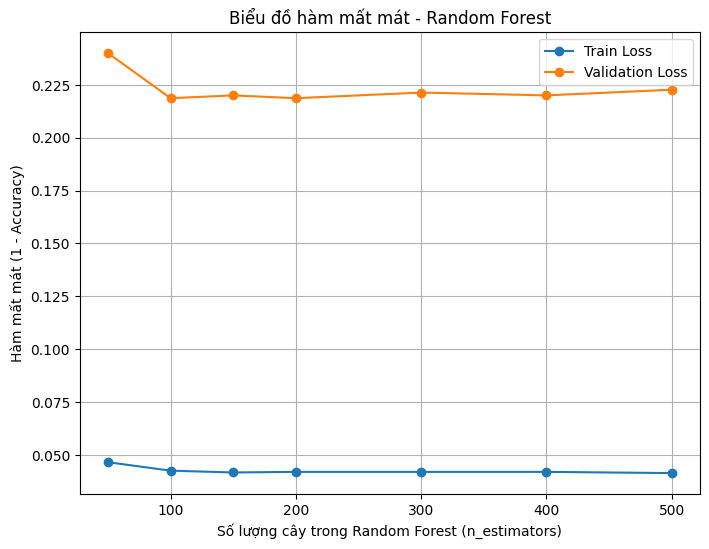

In [19]:
n_trees = [50, 100, 150, 200, 300, 400, 500] 
train_loss = []
val_loss = []

# SỬA LỖI NAMEERROR: Thay 'n_trees' bằng 'n' để khớp với biến n_estimators=n
for n in n_trees:
    
    rf_temp = RandomForestClassifier(
        n_estimators=n, # Biến n đã được định nghĩa qua vòng lặp
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features=0.5,
        bootstrap=True,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    rf_temp.fit(X_train_pca, y_train)

    train_acc = rf_temp.score(X_train_pca, y_train)
    # Đảm bảo dùng y_val, không phải y_val_pca
    val_acc = accuracy_score(y_val, rf_temp.predict(X_val_pca))
    
    train_loss.append(1 - train_acc)
    val_loss.append(1 - val_acc)

# Phần vẽ biểu đồ (Giữ nguyên)
plt.figure(figsize=(8, 6))
plt.plot(n_trees, train_loss, 'o-', label='Train Loss')
plt.plot(n_trees, val_loss, 'o-', label='Validation Loss')
plt.xlabel("Số lượng cây trong Random Forest (n_estimators)")
plt.ylabel("Hàm mất mát (1 - Accuracy)")
plt.title("Biểu đồ hàm mất mát - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

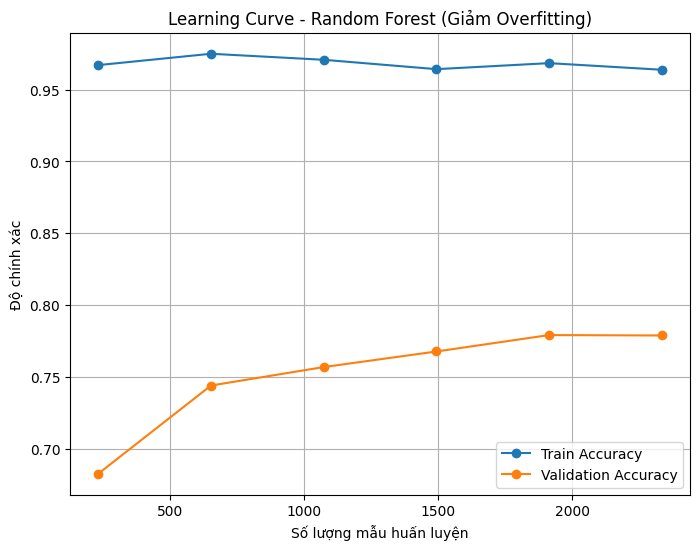

In [20]:
train_sizes, train_scores, val_scores = learning_curve(
    rf, X_train_pca, y_train, cv=3,
    scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6)
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Train Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
plt.xlabel("Số lượng mẫu huấn luyện")
plt.ylabel("Độ chính xác")
plt.title("Learning Curve - Random Forest (Giảm Overfitting)")
plt.legend()
plt.grid(True)
plt.show()

 Accuracy (Test): 74.0 %

Báo cáo chi tiết:
                 precision    recall  f1-score   support

       1.Ipsala       1.00      0.99      0.99        75
    1.gaosengcu       0.36      0.39      0.37        75
      2.Arborio       0.90      0.93      0.92        75
2.gaoxideoBacha       0.66      0.69      0.68        75
    3.Karacadag       0.96      0.93      0.95        75
3.nepcaihoavang       0.61      0.65      0.63        75
      4.Jasmine       0.93      0.95      0.94        75
      4.tamthai       0.58      0.51      0.54        75
      5.Basmati       0.97      0.96      0.97        75
      5.gaoST25       0.43      0.40      0.42        75

       accuracy                           0.74       750
      macro avg       0.74      0.74      0.74       750
   weighted avg       0.74      0.74      0.74       750



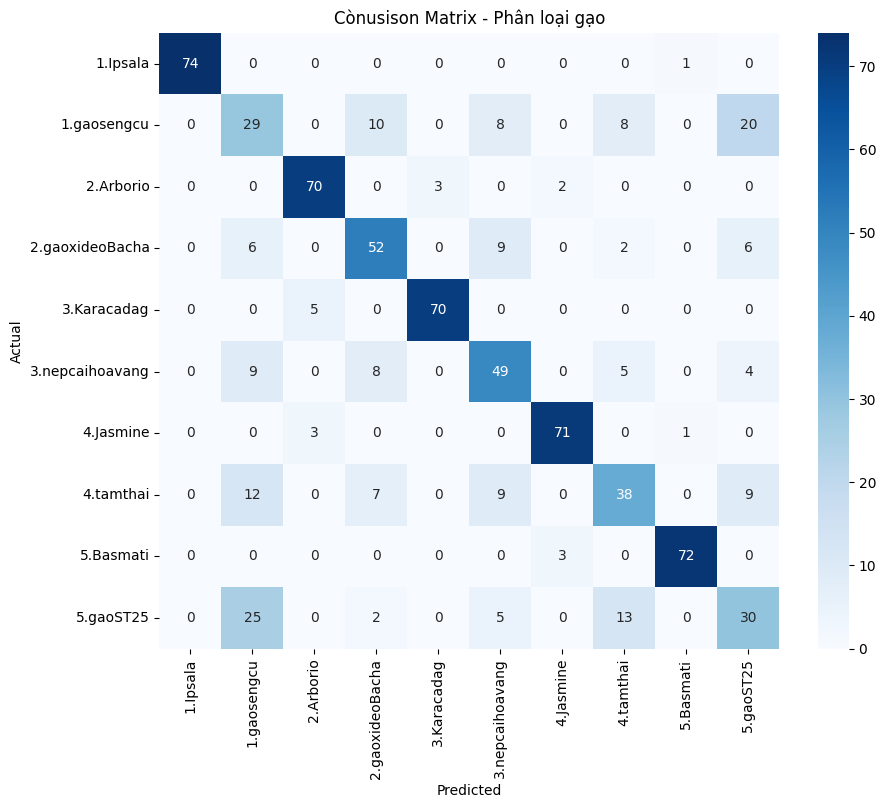

In [21]:
y_pred_test = rf.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred_test)
print(" Accuracy (Test):", round(acc * 100, 2), "%")

print("\nBáo cáo chi tiết:")
print(classification_report(y_test, y_pred_test, target_names=classes))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Cònusison Matrix - Phân loại gạo")
plt.show()

In [22]:
# Tạo DataFrame chứa nhãn thật và nhãn dự đoán
df_results = pd.DataFrame({
    'Thực tế': [classes[i] for i in y_test],
    'Dự đoán': [classes[i] for i in y_pred_test]
})

# Thêm cột đánh dấu đúng/sai
df_results['Kết quả'] = np.where(df_results['Thực tế'] == df_results['Dự đoán'], '✅ Đúng', '❌ Sai')

# Hiển thị 20 dòng đầu tiên
print("📊 Bảng kết quả dự đoán (20 mẫu đầu):")
display(df_results.head(20))

# Tính tỷ lệ đúng/sai theo lớp
summary = df_results.groupby('Thực tế')['Kết quả'].value_counts().unstack(fill_value=0)
summary['Tổng mẫu'] = summary.sum(axis=1)
summary['Độ chính xác (%)'] = (summary['✅ Đúng'] / summary['Tổng mẫu'] * 100).round(2)

print("\n📋 Thống kê độ chính xác theo từng loại gạo:")
display(summary)

📊 Bảng kết quả dự đoán (20 mẫu đầu):


,Thực tế,Dự đoán,Kết quả
0,1.gaosengcu,3.nepcaihoavang,❌ Sai
1,5.Basmati,5.Basmati,✅ Đúng
2,1.gaosengcu,5.gaoST25,❌ Sai
3,3.Karacadag,3.Karacadag,✅ Đúng
4,4.Jasmine,4.Jasmine,✅ Đúng
5,2.Arborio,2.Arborio,✅ Đúng
6,4.Jasmine,4.Jasmine,✅ Đúng
7,2.Arborio,2.Arborio,✅ Đúng
8,5.gaoST25,5.gaoST25,✅ Đúng
9,3.nepcaihoavang,4.tamthai,❌ Sai



📋 Thống kê độ chính xác theo từng loại gạo:


Kết quả,✅ Đúng,❌ Sai,Tổng mẫu,Độ chính xác (%)
Thực tế,,,,
1.Ipsala,74,1,75,98.67
1.gaosengcu,29,46,75,38.67
2.Arborio,70,5,75,93.33
2.gaoxideoBacha,52,23,75,69.33
3.Karacadag,70,5,75,93.33
3.nepcaihoavang,49,26,75,65.33
4.Jasmine,71,4,75,94.67
4.tamthai,38,37,75,50.67
5.Basmati,72,3,75,96.00


In [23]:
import pickle

# Lấy mô hình Random Forest cuối cùng đã huấn luyện
# Giả sử mô hình tốt nhất của bạn là 'rf_final'
# Nếu mô hình cuối cùng trong vòng lặp của bạn là 'rf_temp', hãy sử dụng nó.
rf_final = rf_temp 

# 1. Lưu mô hình Random Forest
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_final, file)

# 2. Lưu PCA và Scaler (QUAN TRỌNG: Nếu bạn dùng PCA và StandardScaler)
# Bạn cần các đối tượng này để tiền xử lý dữ liệu đầu vào mới
# Giả sử bạn đã định nghĩa: scaler (StandardScaler) và pca (PCA)
# Nếu bạn không nhớ tên biến, hãy kiểm tra lại code tiền xử lý của mình.
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
    
with open('pca.pkl', 'wb') as file:
    pickle.dump(pca, file)

print("Đã lưu mô hình, scaler và PCA thành công!")

Đã lưu mô hình, scaler và PCA thành công!


In [1]:
!pip freeze > requirements.txt